<a href="https://colab.research.google.com/github/AlexMachaca/Simulacion-de-Sistemas-Proyecto-Plaza-Vea/blob/main/Grafico_comparativo/04_Simulacion_comparacion_entre_escenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy distfit numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
import pandas as pd
import scipy.stats as st

# 0. PREPARACIÓN DE DATOS (Tus datos reales)

In [4]:
print(">>> Cargando y analizando datos de campo...")

# --- Tus datos crudos ---
caja1_inter = [130, 40, 80, 130, 87, 10, 54, 98, 126, 375, 184, 39, 183, 60, 65, 28, 44, 56, 185, 61, 73, 20, 79, 71, 65, 83, 137]
caja1_serv = [142, 97, 260, 202, 205, 189, 251, 649, 605, 591, 255, 164, 198, 99, 110, 92, 186, 198, 222, 116, 140, 202, 259, 322, 268, 315, 280, 212]
caja2_inter = [30, 10, 120, 396, 789, 27, 80, 118, 207, 88, 40, 120, 595, 18, 112, 75, 185, 81, 87, 54, 8, 200, 143, 59, 522, 94, 44, 540, 327, 769, 422, 9, 159, 195, 997, 868]
caja2_serv = [225, 570, 837, 833, 568, 266, 372, 378, 357, 231, 290, 340, 558, 384, 475, 445, 478, 472, 510, 670, 704, 776, 735, 715, 1688, 1829, 1990, 2088, 1639, 1636, 1036, 2255, 2671, 2590, 2492, 1544, 856]
caja3_inter = [193, 153, 178, 43, 35, 274, 32, 152, 76, 46, 203, 12, 80, 97, 32, 203, 104, 41, 93, 242, 25, 113, 226, 35, 47, 59, 163, 31, 37, 34, 64, 208, 142, 101, 70, 38]
caja3_serv = [325, 247, 161, 182, 218, 258, 65, 75, 136, 106, 184, 145, 287, 321, 321, 337, 166, 120, 264, 357, 291, 333, 251, 89, 139, 145, 212, 75, 97, 99, 94, 191, 288, 346, 335, 320, 409]
caja4_inter = [82, 210, 115, 100, 19, 246, 13, 103, 196, 273, 171, 87, 477, 52, 129, 72, 195, 121, 166]
caja4_serv = [437, 693, 580, 608, 682, 757, 602, 727, 985, 931, 800, 696, 706, 418, 465, 542, 597, 591, 594, 521]

# --- Parámetros globales para la simulación ---
inter_all = np.concatenate([caja1_inter, caja2_inter, caja3_inter, caja4_inter])
serv_all  = np.concatenate([caja1_serv, caja2_serv, caja3_serv, caja4_serv])

MEDIA_LLEGADAS_REAL = np.mean(inter_all)
ALPHA_REAL, LOC_REAL, SCALE_REAL = gamma.fit(serv_all, floc=0)

print(f"Parámetros globales ajustados:")
print(f"  - Media de llegadas (Exponencial): {MEDIA_LLEGADAS_REAL:.2f} seg.")
print(f"  - Parámetros de servicio (Gamma): Alpha={ALPHA_REAL:.2f}, Scale={SCALE_REAL:.2f}")
print("-" * 50)


>>> Cargando y analizando datos de campo...
Parámetros globales ajustados:
  - Media de llegadas (Exponencial): 149.66 seg.
  - Parámetros de servicio (Gamma): Alpha=1.47, Scale=358.65
--------------------------------------------------


# 1. FUNCIONES DE SIMULACIÓN Y ANÁLISIS

In [5]:
def simulacion_replica_multicaja(num_cajas, num_clientes):
    """Ejecuta UNA réplica de la simulación."""
    aleatorios_llegada = np.random.rand(num_clientes)
    t_entre_llegadas = -MEDIA_LLEGADAS_REAL * np.log(1 - aleatorios_llegada)
    t_llegadas = np.cumsum(t_entre_llegadas)

    aleatorios_servicio = np.random.rand(num_clientes)
    t_servicio = gamma.ppf(aleatorios_servicio, a=ALPHA_REAL, scale=SCALE_REAL)

    cajas_estado = [0] * num_cajas
    tiempos_sistema_replica = []

    for i in range(num_clientes):
        idx = np.argmin(cajas_estado)
        inicio = max(cajas_estado[idx], t_llegadas[i])
        fin = inicio + t_servicio[i]
        cajas_estado[idx] = fin
        t_sis = fin - t_llegadas[i]
        tiempos_sistema_replica.append(t_sis)

    return tiempos_sistema_replica

def analizar_escenario_cajas(num_cajas, num_clientes, num_replicas):
    """Ejecuta N réplicas para un escenario y devuelve las estadísticas."""
    print(f"\n--- Analizando escenario: {num_cajas} CAJAS ({num_clientes} clientes, {num_replicas} réplicas) ---")

    promedios_finales_replicas = []
    for _ in range(num_replicas):
        tiempos_sistema = simulacion_replica_multicaja(num_cajas, num_clientes)
        promedios_finales_replicas.append(np.mean(tiempos_sistema))

    media_segundos = np.mean(promedios_finales_replicas)
    std_segundos = np.std(promedios_finales_replicas)

    media_minutos = media_segundos / 60
    std_minutos = std_segundos / 60

    error_estandar_min = st.sem(np.array(promedios_finales_replicas) / 60)
    ic_minutos = st.t.interval(0.95, df=num_replicas-1, loc=media_minutos, scale=error_estandar_min)

    print(f"  Resultados: Tiempo Promedio en Sistema = {media_minutos:.3f} ± {std_minutos:.3f} min.")
    print(f"  Intervalo de Confianza 95%: ({ic_minutos[0]:.3f}, {ic_minutos[1]:.3f}) min.")

    return {
        "Num Cajas": num_cajas,
        "Tiempo Promedio (min)": media_minutos,
        "IC 95% Inferior (min)": ic_minutos[0],
        "IC 95% Superior (min)": ic_minutos[1],
    }

def graficar_comparacion(df_resultados):
    """Genera un gráfico de barras comparativo de los resultados."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    y_err = [
        df_resultados["Tiempo Promedio (min)"] - df_resultados["IC 95% Inferior (min)"],
        df_resultados["IC 95% Superior (min)"] - df_resultados["Tiempo Promedio (min)"]
    ]

    ax.bar(df_resultados["Num Cajas"], df_resultados["Tiempo Promedio (min)"],
           yerr=y_err, capsize=5, color='royalblue', alpha=0.7, ecolor='black', width=0.6)

    ax.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Meta de Tolerancia (5 min)')

    ax.set_title('Comparación de Escenarios: Tiempo en Sistema vs. Número de Cajas', fontsize=16, pad=20)
    ax.set_xlabel('Número de Cajas Operativas', fontsize=12)
    ax.set_ylabel('Tiempo Promedio en Sistema (Minutos)', fontsize=12)
    ax.set_xticks(df_resultados["Num Cajas"])
    ax.legend()
    fig.tight_layout()
    plt.show()

# 2. EJECUCIÓN PRINCIPAL PARA COMPARACIÓN DE ESCENARIOS


--- Analizando escenario: 4 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en Sistema = 16.638 ± 3.878 min.
  Intervalo de Confianza 95%: (15.165, 18.111) min.

--- Analizando escenario: 5 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en Sistema = 10.755 ± 1.245 min.
  Intervalo de Confianza 95%: (10.283, 11.228) min.

--- Analizando escenario: 6 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en Sistema = 9.318 ± 0.619 min.
  Intervalo de Confianza 95%: (9.083, 9.553) min.

--- Analizando escenario: 7 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en Sistema = 8.853 ± 0.485 min.
  Intervalo de Confianza 95%: (8.668, 9.037) min.

--- Analizando escenario: 8 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en Sistema = 8.878 ± 0.450 min.
  Intervalo de Confianza 95%: (8.707, 9.049) min.

--- Analizando escenario: 9 CAJAS (288 clientes, 30 réplicas) ---
  Resultados: Tiempo Promedio en

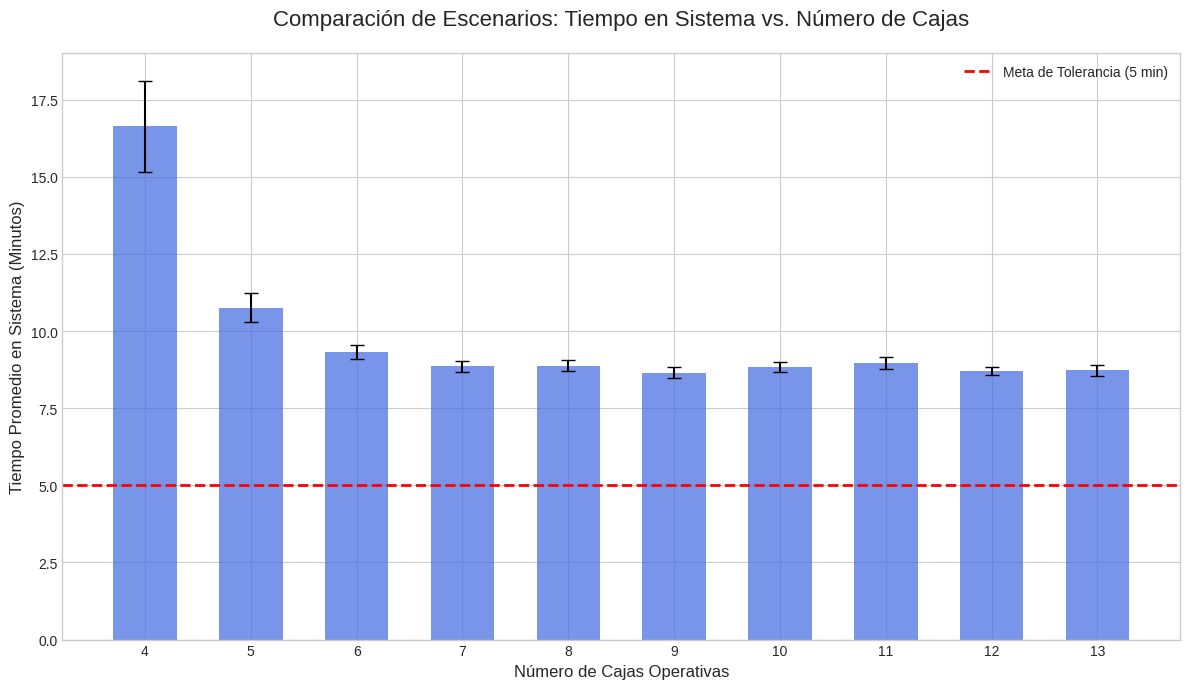

In [ ]:
if __name__ == "__main__":
    # --- Configuración del Experimento ---
    NUM_CLIENTES_POR_REPLICA = 288
    NUM_REPLICAS_POR_ESCENARIO = 30
    ESCENARIOS_A_PROBAR = [ 4,5,6,7,8,9,10,11,12,13]

    # --- Ejecución y Recolección de Resultados ---
    resultados_globales = []
    for n_cajas in ESCENARIOS_A_PROBAR:
        resultado_escenario = analizar_escenario_cajas(
            num_cajas=n_cajas,
            num_clientes=NUM_CLIENTES_POR_REPLICA,
            num_replicas=NUM_REPLICAS_POR_ESCENARIO
        )
        resultados_globales.append(resultado_escenario)

    # --- Presentación de Resultados Finales ---
    df_final = pd.DataFrame(resultados_globales)

    print("\n" + "="*80)
    print("TABLA DE RESULTADOS GLOBALES (Tiempo Promedio en Sistema)")
    print("="*80)
    # Mostramos el DF con formato para mejor lectura
    print(df_final.to_string(index=False, float_format="%.3f"))
    print("="*80)

    # --- Gráfico Comparativo Final ---
    graficar_comparacion(df_final)